# EDS232 Lab 2: Regularized Regression


## Overview
In this lab, you will explore Ridge Regression and Lasso Regression, two common techniques for regularized regression. Both methods add penalties to the regression coefficients, which can help prevent overfitting and improve model interpretability. We will also apply the one-standard-error rule for Lasso regression to select a simpler model.

## Objectives
By the end of this lab, you will:
- Implement Ridge and Lasso regression with cross-validation.
- Compare the performance of Ridge and Lasso models.
- Interpret model coefficients and understand their regularization effects.
- Apply the one-standard-error rule to select a parsimonious Lasso model.

## Key Concepts

**What is Regularized Regression?**
- Regularized regression techniques are used to improve model generalization and prevent overfitting by adding a penalty term to the loss function of linear regression.
- These methods are particularly useful for datasets with:
    - A large number of predictors.
    - High multicollinearity among predictors.
    - A tendency to overfit due to a small number of observations.

**Types of Regularization:**

- Ridge Regression:

    - Adds an L2 penalty ($\lambda \sum_{j=1}^p \beta_j^2 $) to the regression loss function.
    - Shrinks coefficients toward zero but does not set any coefficients exactly to zero.
    - Best suited for reducing multicollinearity and improving model stability.

- Lasso Regression:

    - Adds an L1 penalty ($\lambda \sum_{j=1}^p |\beta_j|$) to the regression loss function.
    - Can shrink some coefficients to exactly zero, effectively performing feature selection.
    - Useful when you want a simpler, interpretable model.



#### About the data

- We will be working with data dealing with physical abalone features. This dataset has observations of more than 4,000 abalone, measuring their length, diameter, height, and different rings. The data can be found here : https://archive.ics.uci.edu/dataset/1/abalone. 


- Notice that the data is not a csv file and is instead a .data file! The .data file does not contain any column names, so we therefore need to specify the column names when we read our data in using `pd.read_csv`. Look at the metadata and assign column names to the data. When you are finished, look at the head of the dataframe to ensure it looks correct. 


In [97]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# URL to the Abalone dataset 
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"

# Define column names based on the UCI repository documentation
column_names = [
    "Sex", "Length", "Diameter", "Height", 
    "Whole_weight", "Shucked_weight", "Viscera_weight", 
    "Shell_weight", "Rings"
]

# Load the dataset
df = pd.read_csv(url, names=column_names)

# Display the first few rows
df.head()
# Explore the data
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole_weight    4177 non-null   float64
 5   Shucked_weight  4177 non-null   float64
 6   Viscera_weight  4177 non-null   float64
 7   Shell_weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB
None
  Sex  Length  Diameter  Height  Whole_weight  Shucked_weight  Viscera_weight  \
0   M   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   M   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   F   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   M 

### Explore the data

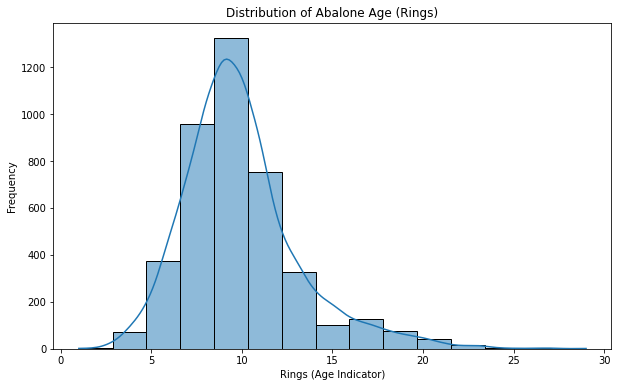

<Axes: >

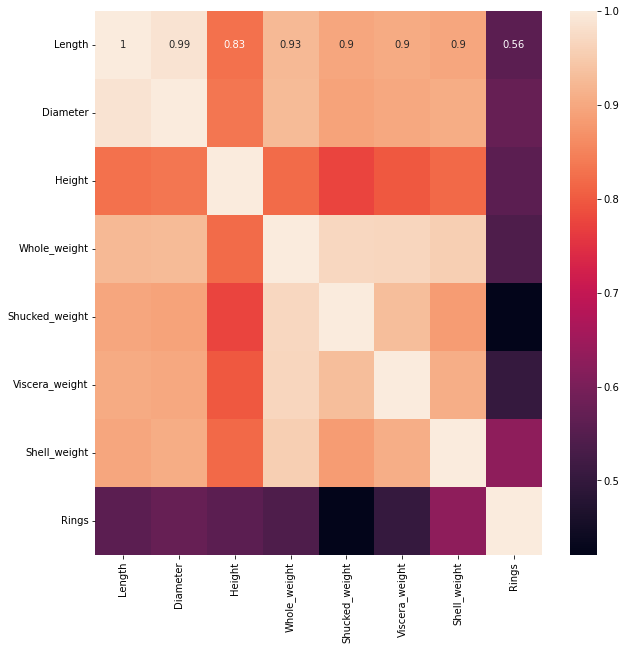

In [118]:
# Explore and Visualize data 
# ex: scatterplot, correlation matrix

# Plot the distribution of Rings (Age Indicator)
plt.figure(figsize=(10, 6))
sns.histplot(df['Rings'], bins=15, kde=True)
plt.title('Distribution of Abalone Age (Rings)')
plt.xlabel('Rings (Age Indicator)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize = (10, 10))
sns.heatmap(df.corr(numeric_only=True), annot = True)

Data Splitting
Question 1: Split the data into training and test sets using a 70/30 split.

In [99]:
# Define predictors and outcome
print(df.columns)

Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight',
       'Viscera_weight', 'Shell_weight', 'Rings'],
      dtype='object')


In [109]:
from sklearn.preprocessing import OneHotEncoder
df_encoded = pd.get_dummies(df, drop_first=True)

X = df_encoded.drop(columns=["Rings"])
y = df_encoded[['Rings']]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

print(X_train)

      Length  Diameter  Height  Whole_weight  Shucked_weight  Viscera_weight  \
1593   0.525     0.380   0.135        0.6150          0.2610          0.1590   
111    0.465     0.360   0.105        0.4310          0.1720          0.1070   
3271   0.520     0.425   0.155        0.7735          0.2970          0.1230   
1089   0.450     0.330   0.105        0.3715          0.1865          0.0785   
2918   0.600     0.445   0.135        0.9205          0.4450          0.2035   
...      ...       ...     ...           ...             ...             ...   
3444   0.490     0.400   0.115        0.5690          0.2560          0.1325   
466    0.670     0.550   0.190        1.3905          0.5425          0.3035   
3092   0.510     0.395   0.125        0.5805          0.2440          0.1335   
3772   0.575     0.465   0.120        1.0535          0.5160          0.2185   
860    0.595     0.475   0.160        1.1405          0.5470          0.2310   

      Shell_weight  Sex_I  Sex_M  
1593

Ridge Regression
Question 2 & 3: Fit a ridge regression model and visualize how coefficients change with lambda.

In [110]:
from sklearn.preprocessing import StandardScaler

# Standardize the predictors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X.shape)
print(X_train_scaled.shape)


(4177, 9)
(2798, 9)


In [111]:
#Fit a regression model
import statsmodels.api as sm

# Add an intercept (required for statsmodels OLS)
X_with_intercept = sm.add_constant(X_train_scaled)

# Fit the model
model = sm.OLS(y_train, X_with_intercept)  # Pass X (with intercept) and y
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Rings   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     367.9
Date:                Thu, 05 Dec 2024   Prob (F-statistic):               0.00
Time:                        13:10:09   Log-Likelihood:                -6166.0
No. Observations:                2798   AIC:                         1.235e+04
Df Residuals:                    2788   BIC:                         1.241e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.9929      0.042    240.723      0.0

In [113]:
# Ridge regression with varying alphas
n_alphas = 50
alphas = np.logspace(-10, -2, n_alphas) # reduced alphas for run time for time being
ridge = RidgeCV(alphas=alphas,  store_cv_results=True) # removing cv = , can't have both cv = and store_cv_results = True

ridge.fit(X_train_scaled, y_train)

RidgeCV(alphas=array([1.00000000e-10, 1.45634848e-10, 2.12095089e-10, 3.08884360e-10,
       4.49843267e-10, 6.55128557e-10, 9.54095476e-10, 1.38949549e-09,
       2.02358965e-09, 2.94705170e-09, 4.29193426e-09, 6.25055193e-09,
       9.10298178e-09, 1.32571137e-08, 1.93069773e-08, 2.81176870e-08,
       4.09491506e-08, 5.96362332e-08, 8.68511374e-08, 1.26485522e-07,
       1.84206997e-07, 2.68269580e-0...
       3.72759372e-06, 5.42867544e-06, 7.90604321e-06, 1.15139540e-05,
       1.67683294e-05, 2.44205309e-05, 3.55648031e-05, 5.17947468e-05,
       7.54312006e-05, 1.09854114e-04, 1.59985872e-04, 2.32995181e-04,
       3.39322177e-04, 4.94171336e-04, 7.19685673e-04, 1.04811313e-03,
       1.52641797e-03, 2.22299648e-03, 3.23745754e-03, 4.71486636e-03,
       6.86648845e-03, 1.00000000e-02]),
        store_cv_results=True)

In [114]:
coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X_train_scaled, y_train)
    coefs.append(ridge.coef_)

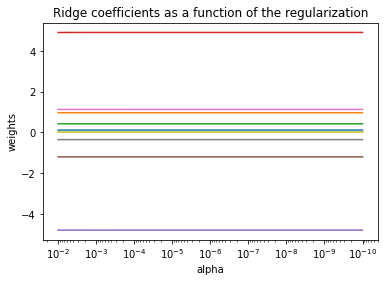

In [115]:
coefs = np.squeeze(coefs)  # Remove dimensions of size 1
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization")
plt.axis("tight")
plt.show()

In [128]:
# Ridge regression with cross-validation
ridge = RidgeCV(alphas=alphas, store_cv_results=True)
ridge.fit(X_train_scaled, y_train.values.ravel())  # Use .ravel() for compatibility

# Extract the cross-validation results
cv_mse = ridge.cv_results_.mean(axis=0)  # Mean MSE across folds for each alpha

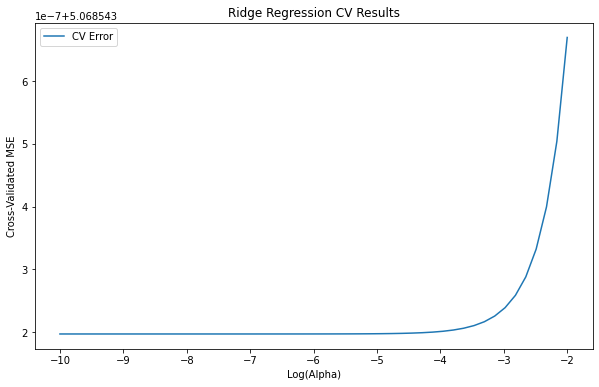

In [130]:
# Plot Ridge results
plt.figure(figsize=(10, 6))
plt.plot(np.log10(alphas), cv_mse, label="CV Error")
#plt.axvline(np.log10(ridge.alpha_), linestyle="--", color="red", label=f"Best Alpha: {ridge.alpha_:.4e}")
plt.xlabel("Log(Alpha)")
plt.ylabel("Cross-Validated MSE")
plt.title("Ridge Regression CV Results")
plt.legend()
plt.show()

Lasso Regression and Cross Validation
Question 4 & 5: Fit lasso regression using LassoCV and interpret the results.

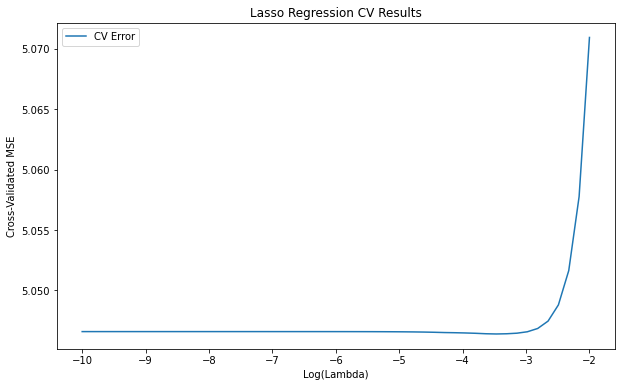

In [119]:
from sklearn.linear_model import LassoCV

# Lasso regression with cross-validation
lasso = LassoCV(alphas=alphas, cv=10, random_state=42)
lasso.fit(X_train_scaled,y_train.values.ravel()) # included .ravel to make 1D to avoid warning message 

# Plot Lasso results
plt.figure(figsize=(10, 6))
plt.plot(np.log10(lasso.alphas_), lasso.mse_path_.mean(axis=1), label="CV Error")
plt.xlabel("Log(Lambda)")
plt.ylabel("Cross-Validated MSE")
plt.title("Lasso Regression CV Results")
plt.legend()
plt.show()


Tuning and Model Comparison
Question 6 & 7: Find the minimum MSE and associated lambda for both Ridge and Lass

In [133]:
# Ridge results
ridge_min_mse = -ridge.best_score_  # Convert negative score to positive MSE
ridge_best_alpha = ridge.alpha_
print(ridge_best_alpha)

1e-10


In [134]:
# Lasso results
lasso_min_mse = lasso.mse_path_.min()
lasso_best_alpha = lasso.alpha_

print(f"Ridge - Minimum MSE: {ridge_min_mse}, Best Alpha: {ridge_best_alpha}")
print(f"Lasso - Minimum MSE: {lasso_min_mse}, Best Alpha: {lasso_best_alpha}")

Ridge - Minimum MSE: 5.068543197311316, Best Alpha: 1e-10
Lasso - Minimum MSE: 3.703120580543633, Best Alpha: 0.0003393221771895323


Question 8: Use the "one-standard-error" rule and find the number of predictors in the Lasso model.

In [21]:
# One-standard-error rule for Lasso
lasso_best_alpha_1se = lasso.alphas_[np.where(
    lasso.mse_path_.mean(axis=1) <= (lasso.mse_path_.mean(axis=1).min() + lasso.mse_path_.std(axis=1).mean())
)[0][0]]

lasso_1se_model = Lasso(alpha=lasso_best_alpha_1se)
lasso_1se_model.fit(X_train_scaled, y_train)

print(f"Lasso 1-SE Rule Alpha: {lasso_best_alpha_1se}")
print(f"Number of Predictors in Lasso (1-SE): {np.sum(lasso_1se_model.coef_ != 0)}")


Lasso 1-SE Rule Alpha: 0.08685113737513521
Number of Predictors in Lasso (1-SE): 1


Question 9: Compare the performance of your Ridge and Lasso models.